# 実測ビームの解析　2次元楕円ガウシアンフィット

In [1]:
import numpy as np
import pandas as pd
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.rcParams.update({'font.size': 18})
mpl.rcParams.update({'axes.facecolor': 'w'})
mpl.rcParams.update({'axes.edgecolor': 'k'})
mpl.rcParams.update({'figure.facecolor': 'w'})
mpl.rcParams.update({'figure.edgecolor': 'w'})
mpl.rcParams.update({'axes.grid': True})
mpl.rcParams.update({'grid.linestyle': ':'})
mpl.rcParams.update({'figure.figsize': [12, 9]})

In [2]:
def get_azel_ant30logdata(filename,linemargin=10,starting_keyword='cmd ='):

    ret = {}

    # file reading
    datalines = ''
    with open(filename)as f:
        datalines= f.readlines()
        pass

    # get center position
    x0 = float(datalines[np.where(['OffX1_HorD' in d for d in datalines])[0][0]].split('\t')[-1]) + \
         float(datalines[np.where(['OffX1_Min' in d for d in datalines])[0][0]].split('\t')[-1])/60 + \
         float(datalines[np.where(['OffX1_Sec' in d for d in datalines])[0][0]].split('\t')[-1])/3600
    y0 = float(datalines[np.where(['OffY1_Deg' in d for d in datalines])[0][0]].split('\t')[-1]) + \
         float(datalines[np.where(['OffY1_Min' in d for d in datalines])[0][0]].split('\t')[-1])/60 + \
         float(datalines[np.where(['OffY1_Sec' in d for d in datalines])[0][0]].split('\t')[-1])/3600
    
    # get target-line region
    tmp = np.where([starting_keyword in d for d in datalines])[0]
    lnbgn = tmp[0] - linemargin
    lnend = tmp[-1] + linemargin

    # Flag to skip lines
    skip = False
    skip_next_line = False
    
    # Process lines within the target region
    for line in datalines[lnbgn:lnend]:
        if 'obsAuto(); Antenna Moving to Off-Point ID=-1' in line:
            skip = True
            print(f"Skipping from line: {line.strip()}")
        elif 'Off-Point Integ end' in line:
            skip = False
            print(f"Resuming at line: {line.strip()}")
            continue
        if skip:
            continue

        if 'obsAuto(); Antenna Moving to On-Point ID=' in line:
            skip_next_line = True
            continue
        elif skip_next_line:
            skip_next_line = False
            continue
        
    # get azel lines
    dl_ri = np.array([l.replace('\n','').replace(',','').replace('[','').replace(']','').split(' ') for l in datalines[lnbgn:lnend] if 'cmd' in l])
    
    # convert line strings to azel or time
    dt = np.array([datetime.datetime.strptime(' '.join(x.split('-')[:2]),'%Y/%m/%d %H:%M:%S.%f') for x in dl_ri[:,0]])
    ts = np.array([x.timestamp() for x in dt])

    cmdaz = np.array([float(x) for x in dl_ri[:,3]])
    cmdel = np.array([float(x) for x in dl_ri[:,4]])

    acuaz = np.array([float(x) for x in dl_ri[:,8]])
    acuel = np.array([float(x) for x in dl_ri[:,9]])
    
    ret['cmd_az'] = cmdaz
    ret['cmd_el'] = cmdel
    ret['actual_az'] = acuaz
    ret['actual_el'] = acuel
    ret['date'] = dt
    ret['timestamp'] = ts
    ret['fn'] = '.'.join(filename.split('/')[-1].split('.')[:-1])
    ret['center'] = (x0,y0)

    # get process time info. for each position moving
    #dl_ri = np.array([l.replace('\n','').replace(',','').replace('[','').replace(']','').split(' ') for l in datalines if 'raster scan timing check' in l])
    #timedelay_dt = np.array([datetime.datetime.strptime(' '.join(x.split('-')[:2]),'%Y/%m/%d %H:%M:%S.%f') for x in dl_ri[:,0]])
    #timedelay = np.array([float(x) for x in dl_ri[:,6]])
    #ret['timedelay'] = timedelay
    #ret['timedelay_dt'] = timedelay_dt
    
    return ret

In [3]:
def get_spadata(filename):
    ret = {}

    spa_pd = pd.read_csv(filename, sep=',', header=None, names=['date','power','psd'])
    ret['date'] = np.array([datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f') for x in spa_pd.date])
    ret['timestamp'] = np.array([x.timestamp() for x in ret['date']])
    ret['power'] = 10**(np.array(spa_pd.power)/10)
    ret['psd'] = 10**(np.array(spa_pd.psd)/10)
    ret['fn'] = '.'.join(filename.split('/')[-1].split('.')[:-1])

    return ret

In [4]:
import scipy 
from scipy import stats

def make_binnedarray(tod_az,tod_el,tod_val,az_bins=None,el_bins=None,select=None,statistic='mean'):
    if az_bins is None:
        az_bins = np.linspace(np.min(tod_az),np.max(tod_az),51)
    if el_bins is None:
        el_bins = np.linspace(np.min(tod_el),np.max(tod_el),51)

    if select is not None and np.shape(select) != np.shape(tod_val):
        print(f"ERROR:: Inconsistent array shape btw select ({np.shape(select)}) and tod_val ({np.shape(tod_val)})")
        return None

    x = None
    y = None
    z = None
    if select is None:
        x = tod_az
        y = tod_el
        z = tod_val
    else:
        x = tod_az[select]
        y = tod_el[select]
        z = tod_val[select]
    ret = stats.binned_statistic_2d(x,y,values=z,statistic=statistic,bins=(az_bins,el_bins))

    return ret.statistic.T,az_bins,el_bins

In [5]:
def make_map(tod_az,tod_el,tod_val,az_bins=None,el_bins=None,select=None,fig=None,ax=None,title='',vmax=None,vmin=None):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    if ax is None:
        if fig is None:
            fig,ax = plt.subplots()
        else:
            ax = fig.axes[0]
    binned_data,_,_ = make_binnedarray(tod_az,tod_el,tod_val,az_bins,el_bins,select)
    im = ax.imshow(binned_data,origin='lower',cmap=mpl.cm.jet,#interpolation='none',
                   extent=(az_bins[0],az_bins[-1],el_bins[0],el_bins[-1]),
                   vmax=vmax,vmin=vmin)
    ax.set_aspect(1)
    ax.set_xlabel('AZ [deg]')
    ax.set_ylabel('EL [deg]')
    ax.set_aspect('equal')
    ax.set_title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=mpl.axes.Axes)
    fig.colorbar(im, cax=cax)
    return fig,ax

import lmfit
def fit_2dgaussian(x,y,z,cent=(None,None),sigma0=[0.2,0.2],theta0=0,userange=None):
    def f(x, y, amp, x0, y0, sigma_x, sigma_y, theta):
        theta = np.radians(theta)
        sigx2 = sigma_x**2; sigy2 = sigma_y**2
        a = np.cos(theta)**2/(2*sigx2) + np.sin(theta)**2/(2*sigy2)
        b = np.sin(theta)**2/(2*sigx2) + np.cos(theta)**2/(2*sigy2)
        c = np.sin(2*theta)/(4*sigx2) - np.sin(2*theta)/(4*sigy2)

        expo = -a*(x-x0)**2 - b*(y-y0)**2 - 2*c*(x-x0)*(y-y0)
        return amp*np.exp(expo)

    fmodel = lmfit.Model(f, independent_vars=('x','y'))
    if userange is None:
        userange = np.array([True]*len(x))

    s = (~np.isnan(x)) & (~np.isnan(y)) & (~np.isnan(z)) & userange

    if not hasattr(sigma0, '__iter__'):
        sigma0 = [sigma0,sigma0]
        pass
    if cent[0] is None or cent[1] is None:
        cent_index = np.argmax(z)
    else:
        cent_index = np.argmin((x-cent[0])**2+(y-cent[1])**2)

    return fmodel.fit(z[s], x=x[s], y=y[s], weights=np.ones_like(x[s]),
                      amp=np.max(z[cent_index-10:cent_index+10]), x0=x[cent_index], y0=y[cent_index],
                      sigma_x=sigma0[0], sigma_y=sigma0[1], theta=theta0)

def get_xy_ellipticalaxis(d,theta,x0,y0,xmin,xmax,ymin,ymax,perpendic=False):
    a = np.tan(theta/180*np.pi)
    if np.abs(a)>1e-9: # line not parallel to x-axis
        if perpendic:
            a = -1/a
        b = y0 - x0 * a
        dx = np.abs(d*np.cos(np.arctan(a)))
        if np.abs((xmax-xmin)/dx)>1e10: # line almost parallel to y-axis
            dy = np.abs(d*np.sin(np.arctan(a)))
            y = np.arange(ymin+dy,ymax,dy)
            x = (y-b)/a
            ss = (xmin<x) & (x<xmax)
        else:
            x = np.arange(xmin+dx,xmax,dx)
            y = a*x + b
            ss = (ymin<y) & (y<ymax)
        pass
    else:
        if not perpendic:
            x = np.arange(xmin+d,xmax,d)
            y = np.array([y0]*len(x))
            ss = np.array([True]*len(x))
        else:
            y = np.arange(ymin+d,ymax,d)
            x = np.array([x0]*len(y))
            ss = np.array([True]*len(x))
    return x[ss], y[ss]


In [6]:
dict_azel = get_azel_ant30logdata(r"ant30-log\ant30-raster_1-20240620142900_2.log")
dict_spa  = get_spadata(r"spa-log\logspa-20240620_143106.txt")

In [7]:
# 2. synchronize az and el to spa data + removed timestamp-out-ranged  data

import scipy
from scipy import signal
from scipy import interpolate

f_az = scipy.interpolate.interp1d(dict_azel['timestamp'],dict_azel['actual_az'])
f_el = scipy.interpolate.interp1d(dict_azel['timestamp'],dict_azel['actual_el'])

ss = np.where((dict_azel['timestamp'][0]<dict_spa['timestamp']) & (dict_spa['timestamp']<dict_azel['timestamp'][-1]))

ret_az = f_az(dict_spa['timestamp'][ss])
ret_el = f_el(dict_spa['timestamp'][ss])
ret_data = dict_spa['power'][ss]

In [8]:
# 4. configuration of map (decide this parameter by seeing map processed below)

step_az = 0.045
step_el = 0.045

# data selection
sel = np.array([True]*len(ret_az))

sel &= ret_az<92
sel &= 89.5<ret_az
sel &= ret_el>0.55
sel &= ret_el<3.05

#sel[:20] = False # remove initial moving of telescope

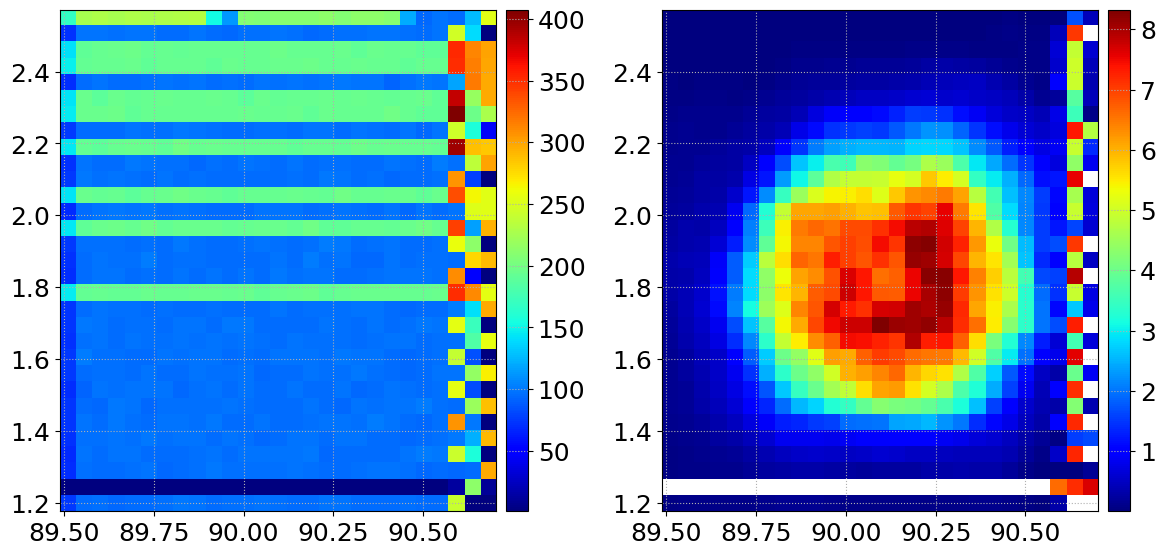

In [9]:
# 4. make map

from mpl_toolkits.axes_grid1 import make_axes_locatable
do_colorbar = True

d = np.max(ret_az[sel]) - np.min(ret_az[sel])
az_bins = np.arange(np.min(ret_az[sel])-0.01*d,np.max(ret_az[sel])+0.99*step_az,step_az)

d = np.max(ret_el[sel]) - np.min(ret_el[sel])
el_bins = np.arange(np.min(ret_el[sel])-0.01*d-step_el*0.5,np.max(ret_el[sel])+0.99*step_el,step_el)

fig,ax = plt.subplots(ncols=2)

z0,_,_ = make_binnedarray(ret_az[sel],ret_el[sel],ret_data[sel],az_bins=az_bins,el_bins=el_bins,statistic='count')
im0 = ax[0].imshow(z0,extent=(az_bins[0],az_bins[-1],el_bins[0],el_bins[-1]),
                   vmax=None,vmin=1,
                   origin='lower',cmap=mpl.cm.jet,interpolation='none')

if do_colorbar:
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=mpl.axes.Axes)
    fig.colorbar(im0, cax=cax)

z1,_,_ = make_binnedarray(ret_az[sel],ret_el[sel],ret_data[sel],az_bins=az_bins,el_bins=el_bins)
z1dBm = np.log10(z1)*10
im1 = ax[1].imshow(z1,vmax=np.nanmax(z1),vmin=np.nanmin(z1),
               extent=(az_bins[0],az_bins[-1],el_bins[0],el_bins[-1]),
               origin='lower',cmap=mpl.cm.jet,interpolation='none')
if do_colorbar:
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=mpl.axes.Axes)
    fig.colorbar(im1, cax=cax)

for iax in ax:
    #iax.set_aspect(1.2)
    #iax.set_xlabel('AZ [arcsec]')
    #iax.set_ylabel('EL [arcsec]')
    iax.set_aspect('equal')

#ax[0].set_title('hitmap')
#ax[1].set_title('SPA power map [mW]')
fig.tight_layout()


In [10]:
import numpy as np
import lmfit
from scipy import signal
from scipy.special import erf

def smooth_elliptical_top_hat_2d(x, y, amplitude, x0, y0, width_x, width_y, sigma, theta, offset):
    """2D rotated elliptical top-hat function with rounded edges using error functions for smooth edges."""
    # Rotate the coordinates
    x_rot = (x - x0) * np.cos(theta) + (y - y0) * np.sin(theta)
    y_rot = -(x - x0) * np.sin(theta) + (y - y0) * np.cos(theta)
    
    # Define the smoothed elliptical top-hat function
    ellipse = ((x_rot / width_x) ** 2 + (y_rot / width_y) ** 2)
    smoothed_ellipse = 0.5 * (erf((1 - ellipse) / (np.sqrt(2) * sigma)) + 1)
    
    return offset + amplitude * smoothed_ellipse

def fit_smooth_elliptical_top_hat_2d(x, y, z, medfilt=11):
    """
    Fit a 2D rotated elliptical top-hat model with rounded edges to x, y, z data.

    Parameters:
    x, y, z : 1D numpy arrays
        The x, y coordinates and z values of the data points to be fitted.
    medfilt : int, optional
        The size of the median filter to be applied to the data.

    Returns:
    result : lmfit.model.ModelResult
        The fitting result for the 2D data.
    """
    # Apply median filter to the z data
    z_sm = signal.medfilt(z, medfilt)
    
    # Initial guess for the parameters
    amplitude = np.nanmax(z_sm) - np.nanmedian(z_sm)
    max_ind = np.nanargmax(z_sm)
    x0, y0 = x[max_ind], y[max_ind]
    width_x = width_y = (np.nanmax(x) - np.nanmin(x)) / 4  # Initial guess for the widths
    sigma = (np.nanmax(x) - np.nanmin(x)) / 20  # Initial guess for the rounding parameter
    theta = 0  # Initial guess for the rotation angle
    offset = np.nanmedian(z_sm)
    
    # Create the lmfit model
    model = lmfit.Model(smooth_elliptical_top_hat_2d, independent_vars=['x', 'y'])
    
    # Create the parameters
    params = model.make_params(
        amplitude=amplitude,
        x0=x0,
        y0=y0,
        width_x=width_x,
        width_y=width_y,
        sigma=sigma,
        theta=theta,
        offset=offset
    )
    
    # Set bounds for the parameters
    params['amplitude'].set(min=0)
    params['width_x'].set(min=0)
    params['width_y'].set(min=0)
    params['sigma'].set(min=0)
    params['theta'].set(min=-np.pi, max=np.pi)
    
    # Fit the model to the data
    result = model.fit(data=z, x=x, y=y, params=params, method='nelder')# 'leastsq'
    
    return result

In [11]:
def fit_rectanglegauss_ellipticalaxis(x,y,z,fitresult,delta,xmin,xmax,ymin,ymax,x_bins,y_bins,plot=False,userange=None,cent=None,theta=None):
    if userange is None:
        userange = np.array([True]*len(x))

    binned_data,_,_ = make_binnedarray(x[userange],y[userange],z[userange],x_bins,y_bins)
    #print(np.shape(binned_data))
    if len(np.where(np.isnan(binned_data))[0])>0:
        binned_data[np.isnan(binned_data)] = 0.0
    f = scipy.interpolate.interp2d(x=x_bins[:-1],y=y_bins[:-1],z=binned_data,kind='cubic')
    if theta is None:
        theta = fitresult.params['theta'].value
    majorx, majory = get_xy_ellipticalaxis(delta,
                                           theta,
                                           fitresult.params['x0'].value,
                                           fitresult.params['y0'].value,
                                           xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax)
    interp_data = np.array([f(ix,iy)[0] for ix,iy in zip(majorx, majory)])
    interp_ax   = np.array([delta*i for i in np.arange(len(interp_data))])

    majorpos = (majorx, majory)
    majorax = interp_ax
    majordata = interp_data

    minorx, minory = get_xy_ellipticalaxis(delta,
                                           theta,
                                           fitresult.params['x0'].value,
                                           fitresult.params['y0'].value,
                                           xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,
                                           perpendic=True)
    interp_data = np.array([f(ix,iy)[0] for ix,iy in zip(minorx, minory)])
    interp_ax   = np.array([delta*i for i in np.arange(len(interp_data))])

    minorpos = (minorx, minory)
    minorax = interp_ax
    minordata = interp_data

    if plot:
        fig,ax = plt.subplots(ncols=3,figsize=(15,4))
        make_map(x,y,z,az_bins=x_bins,el_bins=y_bins,fig=fig,ax=ax[0])
        ax[0].plot(majorpos[0],majorpos[1],ls='-',lw=2,color='w')
        ax[0].plot(minorpos[0],minorpos[1],ls=':',lw=2,color='w')
        ax[0].scatter(fitresult.params['x0'].value,fitresult.params['y0'].value,marker='o',color='w')
        ax[0].set_title('data with elliptical axis [mW]')
        ax[1].plot(majorax,majordata,'ko')
        ax[1].set_title('1st axis sliced data (solid line)')
        ax[1].set_xlabel('degree on 1st aixs [deg]')
        ax[1].set_ylabel('data [mW]')
        ax[2].plot(minorax,minordata,'ko')
        ax[2].set_title('2nd axis sliced data (dotted line)')
        ax[2].set_xlabel('degree on 2nd aixs [deg]')
        ax[2].set_ylabel('data [mW]')
        plt.show()

    #fitresult_majorax = fit_rectgaussian(majorax,majordata)
    #fitresult_minorax = fit_rectgaussian(minorax,minordata)

    return majorax,majordata,minorax,minordata

C:\Users\enohi\AppData\Local\Temp\ipykernel_6232\3682241129.py:35: RuntimeWarning: invalid value encountered in log10
  z1dBm = np.log10(z1)*10
C:\Users\enohi\AppData\Local\Temp\ipykernel_6232\1116557086.py:9: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = scipy.interpolate.interp2d(x=x_bins[:-1],y=y_bins[:-1],z=binned_data,kind='cubic')
C:\Users\enohi\AppData\Local\Temp\ipykernel_6232\1116557086.py:17: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will

fitted center position (AZ, EL) = (90.13046001150165,1.8117894845734344) deg


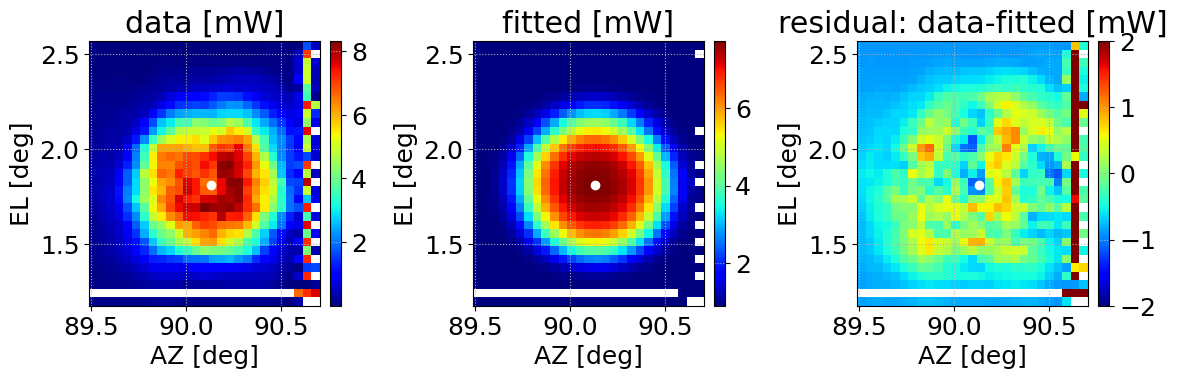

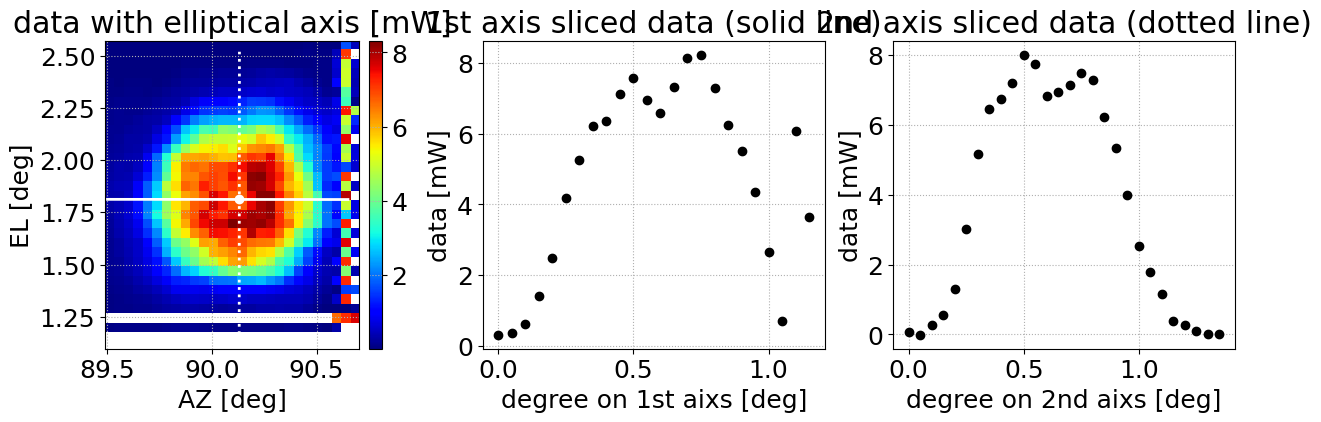

In [12]:
# 8. 2d rectange+gaussian fitting

result = fit_smooth_elliptical_top_hat_2d(ret_az,ret_el,ret_data)

result.params['theta'].set(min=0, max=np.pi)
cent = (result.params['x0'].value,result.params['y0'].value)

fit_data = result.eval(result.params,x=ret_az,y=ret_el,userange=sel)

fig,ax = plt.subplots(ncols=3)
z1,_,_ = make_binnedarray(ret_az[sel],ret_el[sel],ret_data[sel],az_bins=az_bins,el_bins=el_bins)
z1dBm = np.log10(z1)*10
im1 = ax[0].imshow(z1,vmax=np.nanmax(z1),vmin=np.nanmin(z1),
               extent=(az_bins[0],az_bins[-1],el_bins[0],el_bins[-1]),
               origin='lower',cmap=mpl.cm.jet,interpolation='none')

ax[0].scatter(cent[0],cent[1],marker='o',color='w')
if do_colorbar:
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=mpl.axes.Axes)
    fig.colorbar(im1, cax=cax)

z1,_,_ = make_binnedarray(ret_az[sel],ret_el[sel],fit_data[sel],az_bins=az_bins,el_bins=el_bins)
z1dBm = np.log10(z1)*10
im1 = ax[1].imshow(z1,vmax=np.nanmax(z1),vmin=np.nanmin(z1),
               extent=(az_bins[0],az_bins[-1],el_bins[0],el_bins[-1]),
               origin='lower',cmap=mpl.cm.jet,interpolation='none')
ax[1].scatter(cent[0],cent[1],marker='o',color='w')
if do_colorbar:
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=mpl.axes.Axes)
    fig.colorbar(im1, cax=cax)

z1,_,_ = make_binnedarray(ret_az[sel],ret_el[sel],ret_data[sel]-fit_data[sel],az_bins=az_bins,el_bins=el_bins)
z1dBm = np.log10(z1)*10
im1 = ax[2].imshow(z1,vmax=2,vmin=-2,
               extent=(az_bins[0],az_bins[-1],el_bins[0],el_bins[-1]),
               origin='lower',cmap=mpl.cm.jet,interpolation='none')
ax[2].scatter(cent[0],cent[1],marker='o',color='w')
if do_colorbar:
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=mpl.axes.Axes)
    fig.colorbar(im1, cax=cax)

for iax in ax:
    iax.set_aspect(1)
    iax.set_xlabel('AZ [deg]')
    iax.set_ylabel('EL [deg]')
    iax.set_aspect('equal')

ax[0].set_title('data [mW]')
ax[1].set_title('fitted [mW]')
ax[2].set_title('residual: data-fitted [mW]')
fig.tight_layout()

print(f"fitted center position (AZ, EL) = ({result.params['x0'].value},{result.params['y0'].value}) deg")

majorax,majordata,minorax,minordata = fit_rectanglegauss_ellipticalaxis(ret_az[sel],ret_el[sel],ret_data[sel],result,delta=0.05,
                                                                        xmin=np.nanmin(ret_az[sel])-0.05,xmax=np.nanmax(ret_az[sel])+0.01,
                                                                        ymin=np.nanmin(ret_el[sel])-0.05,ymax=np.nanmax(ret_el[sel])+0.01,
                                                                        x_bins=az_bins,y_bins=el_bins,plot=True,userange=None)

FWHM in EL direction (row 10, EL~1.63 deg): 0.6300000000000239 deg
FWHM in AZ direction could not be determined.


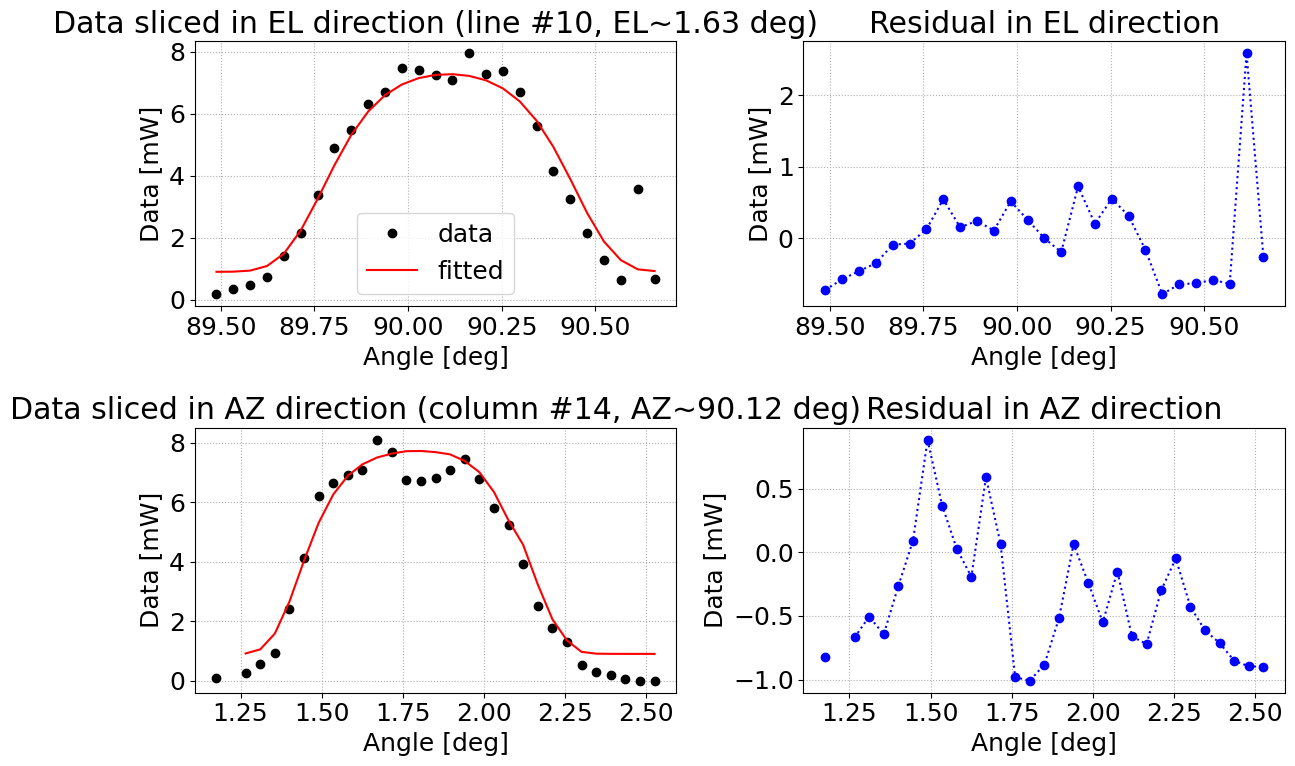

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 特定の行と列を選択（EL方向とAZ方向）
irow = 10  # EL方向の行
icol = 14  # AZ方向の列

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# EL方向のデータとフィッティングデータの取得
z1_data, _, _ = make_binnedarray(ret_az[sel], ret_el[sel], ret_data[sel], az_bins=az_bins, el_bins=el_bins)
el_data_profile = z1_data[irow]
ax[0, 0].plot(az_bins[:-1], el_data_profile, 'ok', label='data')

z1_fit, _, _ = make_binnedarray(ret_az[sel], ret_el[sel], fit_data[sel], az_bins=az_bins, el_bins=el_bins)
el_fitted_profile = z1_fit[irow]
ax[0, 0].plot(az_bins[:-1], el_fitted_profile, '-r', label='fitted')

# 残差プロファイル（EL方向）
el_residual_profile = el_data_profile - el_fitted_profile
ax[0, 1].plot(az_bins[:-1], el_residual_profile, 'ob:')

# EL方向のFWHMの計算
el_peak_value = np.max(el_fitted_profile)
el_half_max = el_peak_value / 2  # FWHM の基準

# 半分の最大値を越えるデータ点のインデックスを取得
el_above_half_max_indices = np.where(el_fitted_profile >= el_half_max)[0]

if len(el_above_half_max_indices) >= 2:
    el_fwhm_start = az_bins[el_above_half_max_indices[0]]
    el_fwhm_end = az_bins[el_above_half_max_indices[-1]]
    el_fwhm = el_fwhm_end - el_fwhm_start
    print(f"FWHM in EL direction (row {irow}, EL~{np.mean(el_bins[irow:irow+1]):.2f} deg): {el_fwhm} deg")
else:
    print("FWHM in EL direction could not be determined.")

# AZ方向のデータとフィッティングデータの取得
az_data_profile = z1_data[:, icol]
ax[1, 0].plot(el_bins[:-1], az_data_profile, 'ok', label='data')

az_fitted_profile = z1_fit[:, icol]
ax[1, 0].plot(el_bins[:-1], az_fitted_profile, '-r', label='fitted')

# 残差プロファイル（AZ方向）
az_residual_profile = az_data_profile - az_fitted_profile
ax[1, 1].plot(el_bins[:-1], az_residual_profile, 'ob:')

# AZ方向のFWHMの計算
az_peak_value = np.max(az_fitted_profile)
az_half_max = az_peak_value / 2  # FWHM の基準

# 半分の最大値を越えるデータ点のインデックスを取得
az_above_half_max_indices = np.where(az_fitted_profile >= az_half_max)[0]

if len(az_above_half_max_indices) >= 2:
    az_fwhm_start = el_bins[az_above_half_max_indices[0]]
    az_fwhm_end = el_bins[az_above_half_max_indices[-1]]
    az_fwhm = az_fwhm_end - az_fwhm_start
    print(f"FWHM in AZ direction (col {icol}, AZ~{np.mean(az_bins[icol:icol+1]):.2f} deg): {az_fwhm} deg")
else:
    print("FWHM in AZ direction could not be determined.")

# プロット設定
for iax in ax.flatten():
    iax.set_xlabel('Angle [deg]')
    iax.set_ylabel('Data [mW]')

ax[0, 0].set_title(f'Data sliced in EL direction (line #{irow}, EL~{np.mean(el_bins[irow:irow+1]):.2f} deg)')
ax[0, 1].set_title('Residual in EL direction')
ax[1, 0].set_title(f'Data sliced in AZ direction (column #{icol}, AZ~{np.mean(az_bins[icol:icol+1]):.2f} deg)')
ax[1, 1].set_title('Residual in AZ direction')

ax[0, 0].legend()
fig.tight_layout()


FWHM in EL direction (row 11, EL~1.67 deg): 0.6300 deg
FWHM in AZ direction could not be determined.


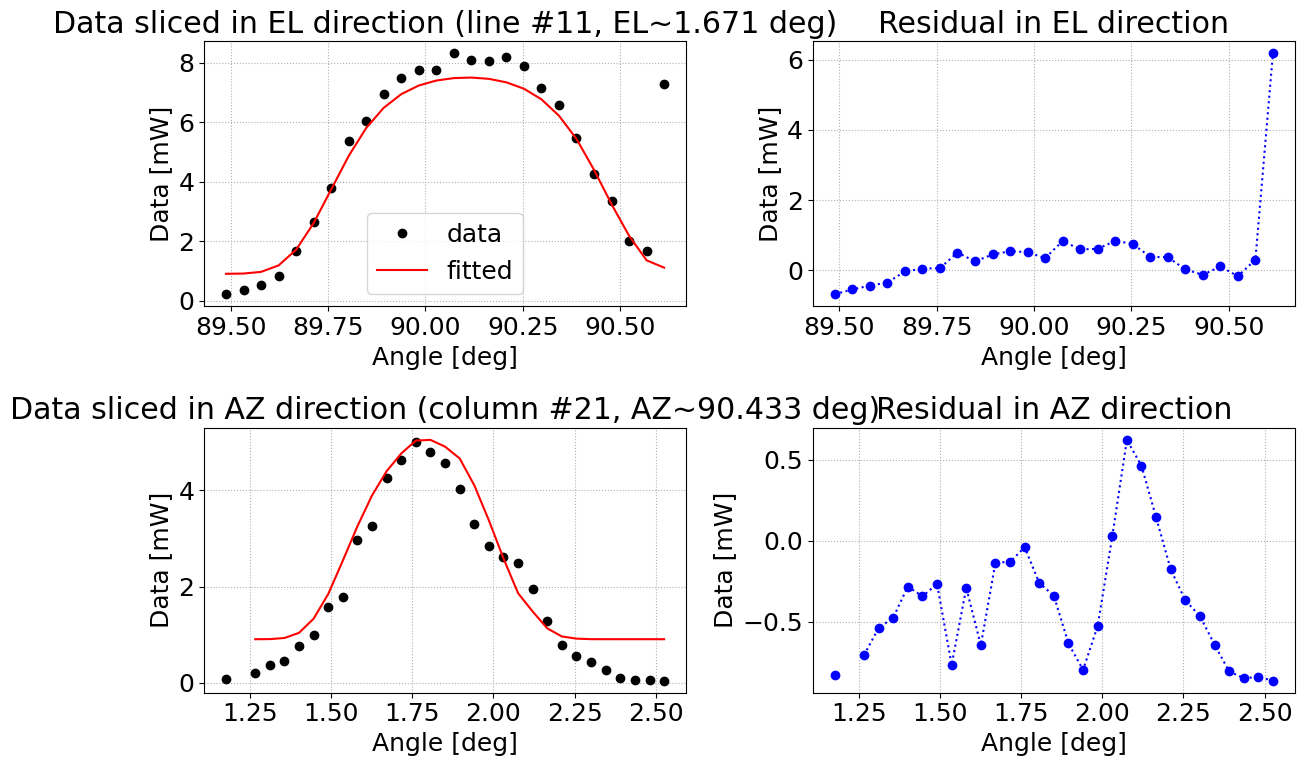

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 特定の行と列を選択（EL方向とAZ方向）
irow = 11  # EL方向の行
icol = 21  # AZ方向の列

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# EL方向のデータとフィッティングデータの取得
z1_data, _, _ = make_binnedarray(ret_az[sel], ret_el[sel], ret_data[sel], az_bins=az_bins, el_bins=el_bins)
el_data_profile = z1_data[irow]
ax[0, 0].plot(az_bins[:-1], el_data_profile, 'ok', label='data')

z1_fit, _, _ = make_binnedarray(ret_az[sel], ret_el[sel], fit_data[sel], az_bins=az_bins, el_bins=el_bins)
el_fitted_profile = z1_fit[irow]
ax[0, 0].plot(az_bins[:-1], el_fitted_profile, '-r', label='fitted')

# EL Fitted Profile に NaN を除去
el_fitted_profile = np.nan_to_num(el_fitted_profile, nan=0)

# FWHM の計算（EL方向、赤線のfitted data）
el_peak_value = np.max(el_fitted_profile)
el_half_max = el_peak_value / 2  # 半分の最大値

# 半分の最大値を越えるデータ点のインデックスを取得
el_above_half_max_indices = np.where(el_fitted_profile >= el_half_max)[0]

if len(el_above_half_max_indices) >= 2:
    el_fwhm_start = az_bins[el_above_half_max_indices[0]]
    el_fwhm_end = az_bins[el_above_half_max_indices[-1]]
    el_fwhm = el_fwhm_end - el_fwhm_start
    print(f"FWHM in EL direction (row {irow}, EL~{np.mean(el_bins[irow:irow+1]):.2f} deg): {el_fwhm:.4f} deg")
else:
    print("FWHM in EL direction could not be determined.")

# AZ方向のデータとフィッティングデータの取得
az_data_profile = z1_data[:, icol]
ax[1, 0].plot(el_bins[:-1], az_data_profile, 'ok', label='data')

az_fitted_profile = z1_fit[:, icol]
ax[1, 0].plot(el_bins[:-1], az_fitted_profile, '-r', label='fitted')

# FWHM の計算（AZ方向、赤線のfitted data）
az_peak_value = np.max(az_fitted_profile)
az_half_max = az_peak_value / 2  # 半分の最大値

# 半分の最大値を越えるデータ点のインデックスを取得
az_above_half_max_indices = np.where(az_fitted_profile >= az_half_max)[0]

if len(az_above_half_max_indices) >= 2:
    az_fwhm_start = el_bins[az_above_half_max_indices[0]]
    az_fwhm_end = el_bins[az_above_half_max_indices[-1]]
    az_fwhm = az_fwhm_end - az_fwhm_start
    print(f"FWHM in AZ direction (col {icol}, AZ~{np.mean(az_bins[icol:icol+1]):.2f} deg): {az_fwhm:.4f} deg")
else:
    print("FWHM in AZ direction could not be determined.")

# 残差プロファイルの計算とプロット（EL方向）
el_residual_profile = el_data_profile - el_fitted_profile
ax[0, 1].plot(az_bins[:-1], el_residual_profile, 'ob:')
ax[0, 1].set_title('Residual in EL direction')

# 残差プロファイルの計算とプロット（AZ方向）
az_residual_profile = az_data_profile - az_fitted_profile
ax[1, 1].plot(el_bins[:-1], az_residual_profile, 'ob:')
ax[1, 1].set_title('Residual in AZ direction')

# プロット設定
for iax in ax.flatten():
    iax.set_xlabel('Angle [deg]')
    iax.set_ylabel('Data [mW]')

ax[0, 0].set_title(f'Data sliced in EL direction (line #{irow}, EL~{np.mean(el_bins[irow:irow+1]):.3f} deg)')
ax[1, 0].set_title(f'Data sliced in AZ direction (column #{icol}, AZ~{np.mean(az_bins[icol:icol+1]):.3f} deg)')

ax[0, 0].legend()
fig.tight_layout()
plt.show()


# **フィッティング関数について**

## **1. `smooth_elliptical_top_hat_2d` のモデル**

- **中心部分で一定の強度**
- **エッジ部分が滑らかに減衰**
- **楕円形で任意の角度で回転可能**

---

### **1.1 回転座標の定義**
楕円を任意の角度 $\theta$ で回転させるために、与えられた座標 $(x, y)$ を回転座標 $(x_{\text{rot}}, y_{\text{rot}})$ に変換：

$$
\begin{aligned}
x_{\text{rot}} &= (x - x_0) \cos\theta + (y - y_0) \sin\theta, \\
y_{\text{rot}} &= -(x - x_0) \sin\theta + (y - y_0) \cos\theta,
\end{aligned}
$$

ここで、$(x_0, y_0)$ は楕円の中心座標。

---

### **1.2 楕円の方程式**
回転後の座標で楕円の形状を記述。楕円の形状は以下の式で表される：

$$
\text{ellipse} = \left( \frac{x_{\text{rot}}}{\text{width}_x} \right)^2 + \left( \frac{y_{\text{rot}}}{\text{width}_y} \right)^2,
$$

ここで：
- $\text{width}_x, \text{width}_y$: 楕円の x, y 軸方向の半径（幅）。
- $\text{ellipse} \leq 1$: トップハット部分を表します。

---

### **1.3 スムージング**
楕円形状のエッジを滑らかにするため、誤差関数（`erf`）を使用。

スムージングされた楕円形状は以下の式で定義される：

$$
\text{smoothed\_ellipse} = \frac{1}{2} \left[ \text{erf}\left( \frac{1 - \text{ellipse}}{\sqrt{2} \sigma} \right) + 1 \right],
$$

ここで：
- $\sigma$: エッジの滑らかさを制御するパラメータ。
- $\text{erf}(x)$: エラーファンクション。
  $$
  \text{erf}(x) = \frac{2}{\sqrt{\pi}} \int_0^x e^{-t^2} dt.
  $$

---

### **1.4 トップハットの強度モデル**
振幅（中心強度）とオフセット（背景強度）を加える。：

$$
f(x, y) = \text{offset} + \text{amplitude} \cdot \text{smoothed\_ellipse},
$$

ここで：
- $\text{offset}$: 背景強度。
- $\text{amplitude}$: 中心の強度。

---
### **2 初期パラメータの推定**
- **振幅**:
  $$
  \text{amplitude} = \max(z_{\text{sm}}) - \text{median}(z_{\text{sm}})
  $$
- **楕円の中心**: 最大強度の位置 $(x_0, y_0)$。
- **楕円の幅**: 
  データ範囲に基づいて、初期幅 $\text{width}_x, \text{width}_y$ を計算。
- **エッジの滑らかさ**: 
  データ範囲に基づいて、初期値 $\sigma$ を設定。
- **背景強度**:
  $$
  \text{offset} = \text{median}(z_{\text{sm}})
  $$



# `smooth_elliptical_top_hat_2d` のモデル式：

$$
f(x, y) = \text{offset} + \text{amplitude} \cdot \frac{1}{2} \left[ \text{erf}\left( \frac{1 - \left( \frac{(x - x_0) \cos\theta + (y - y_0) \sin\theta}{\text{width}_x} \right)^2 - \left( \frac{-(x - x_0) \sin\theta + (y - y_0) \cos\theta}{\text{width}_y} \right)^2}{\sqrt{2} \sigma} \right) + 1 \right]
$$

## 各パラメーターについて
- \( $f(x, y)$ \): 与えられた座標 \($(x, y)$\) における強度
- \($\text{offset}$\): 背景強度
- \($\text{amplitude}$\): 楕円形内の最大強度
- \($(x_0, y_0)$\): 楕円の中心座標
- \($\text{width}_x, \text{width}_y$\): 楕円の x, y 軸方向の半径（幅）
- \(\sigma\): エッジの滑らかさを制御するパラメーター
- \(\theta\): 楕円の回転角度
- \(\text{erf}(x)\): 誤差関数
  $$
  \text{erf}(x) = \frac{2}{\sqrt{\pi}} \int_0^x e^{-t^2} dt
  $$



In [15]:
# デバッグ用の出力
print(f"EL Fitted Profile: {el_fitted_profile}")
print(f"Half-Max Value: {el_half_max}")
print(f"Indices Above Half-Max: {np.where(el_fitted_profile >= el_half_max)[0]}")
print(f"Length of az_bins[:-1]: {len(az_bins[:-1])}")
print(f"Length of el_fitted_profile: {len(el_fitted_profile)}")
print(f"NaN in EL Fitted Profile: {np.isnan(el_fitted_profile).any()}")
print(f"Max Value in EL Fitted Profile: {np.max(el_fitted_profile)}")


EL Fitted Profile: [0.90888762 0.91720061 0.97384967 1.19051198 1.71778497 2.61227942
 3.74188518 4.86853958 5.80863432 6.48769434 6.94618061 7.23596601
 7.40315736 7.48521689 7.50315492 7.46009024 7.34272626 7.12864475
 6.77209094 6.22125741 5.44066842 4.40167407 3.24752276 2.18733653
 1.36225586 1.11503995 0.        ]
Half-Max Value: 3.75157745830438
Indices Above Half-Max: [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Length of az_bins[:-1]: 27
Length of el_fitted_profile: 27
NaN in EL Fitted Profile: False
Max Value in EL Fitted Profile: 7.50315491660876


In [39]:
# フィッティングされた全てのパラメータの出力
print("All fitted parameters:")

for param_name, param in result.params.items():
    print(f"{param_name}: {param.value} ± {param.stderr if param.stderr else 'N/A'}")

All fitted parameters:
amplitude: 10.365830653501062 ± N/A
x0: 89.74903362525593 ± N/A
y0: 1.6082556882788257 ± N/A
width_x: 0.26557759743746545 ± N/A
width_y: 0.2864199733922106 ± N/A
sigma: 0.7300150250049644 ± N/A
theta: -0.22795209304481423 ± N/A
offset: 0.13083839023864272 ± N/A


In [16]:
width_x = result.params['width_x'].value
width_y = result.params['width_y'].value

# FWHM の計算
fwhm_x = 2 * np.sqrt(2 * np.log(2)) * width_x
fwhm_y = 2 * np.sqrt(2 * np.log(2)) * width_y

# 結果の表示
print(f"FWHM in x-direction: {fwhm_x} deg")
print(f"FWHM in y-direction: {fwhm_y} deg")


FWHM in x-direction: 0.8195979521378144 deg
FWHM in y-direction: 0.7734216855761922 deg
